# Exploratory data analysis
This is a template notebook for exploratory analysis on your organism's QC'ed dataset.

In [1]:
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
sns.set_style('ticks')

## Load data

In [67]:
metadata_file = path.join('..', 'example_data', 'processed_data', 'metadata.tsv')
logTPM_file = path.join('..', 'example_data', 'processed_data', 'log_tpm.csv')
DF_metadata = pd.read_csv(metadata_file, sep='\t', index_col=0)
DF_log_tpm = pd.read_csv(logTPM_file,index_col=0)

## Quality control pie chart

In [68]:
metadata_qc = path.join('..', 'example_data','interim','metadata_qc_part2_all.tsv')
DF_metadata_qc = pd.read_csv(metadata_qc, sep='\t', index_col=0)

In [69]:
# Step 1: Check FastQC
failed_step1 = DF_metadata_qc[~DF_metadata_qc.passed_fastqc].index
df_passed_step1 = DF_metadata_qc[DF_metadata_qc.passed_fastqc]

# Step 2: Check number of reads mapped to CDS
failed_step2 = df_passed_step1[~df_passed_step1.passed_reads_mapped_to_CDS].index
df_passed_step2 = df_passed_step1[df_passed_step1.passed_reads_mapped_to_CDS]

# Step 3: Check global correlations
failed_step3 = df_passed_step2[~df_passed_step2.passed_global_correlation].index
df_passed_step3 = df_passed_step2[df_passed_step2.passed_global_correlation]

# Step 4: Check curation
failed_step4 = df_passed_step3[~df_passed_step3.passed_curation].index
df_passed_step4 = df_passed_step3[df_passed_step3.passed_curation]

# Step 5: Check replicate correlations
failed_step5 = df_passed_step4[~df_passed_step4.passed_replicate_correlations].index
df_passed_step5 = df_passed_step4[df_passed_step4.passed_replicate_correlations]

In [70]:
print('Total failed:',len(failed_step1) + len(failed_step2) + len(failed_step3) + len(failed_step4) + len(failed_step5))
print('Total passed:',len(DF_metadata))

Total failed: 443
Total passed: 265


In [71]:
values = [len(DF_metadata),
          len(failed_step1),
          len(failed_step2),
          len(failed_step3),
          len(failed_step4),
          len(failed_step5)]
labels = ['Passed','Failed FastQC','Too few reads mapped to CDS','Poor correlation with other datasets','Problems with metadata','Poor correlation between replicates']

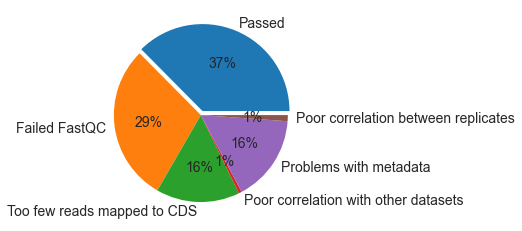

In [72]:
plt.pie(values,labels=labels,autopct = '%.0f%%',textprops={'fontsize':14},wedgeprops={'linewidth':0},explode=[.05,0,0,0,0,0]);

## Plot growth of dataset

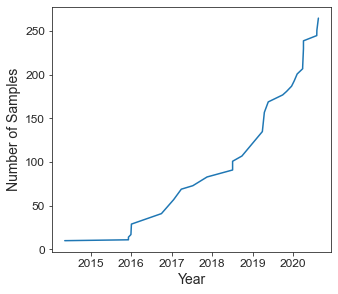

In [73]:
DF_metadata['ReleaseDate'] = pd.to_datetime(DF_metadata['ReleaseDate'])

first_date = min(DF_metadata['ReleaseDate'])
last_date = max(DF_metadata['ReleaseDate'])
date_range = pd.date_range(start=first_date,end=last_date,freq='YS')

fig,ax = plt.subplots(figsize=(5,5))
growth = DF_metadata['ReleaseDate'].value_counts().sort_index().cumsum()
growth.plot(ax=ax,label='All samples')
plt.xticks(date_range,date_range.strftime('%Y'),rotation=0,ha='center')
ax.tick_params(labelsize=12)
ax.set_xlabel('Year',fontsize=14)
ax.set_ylabel('Number of Samples',fontsize=14)
None

## Principal component analysis

First compute principal components.

In [74]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(DF_log_tpm.T),index=DF_log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T,index=DF_log_tpm.index)

Next, plot the cumulative explained variance

Number of dimensions for 99% of variance: 122


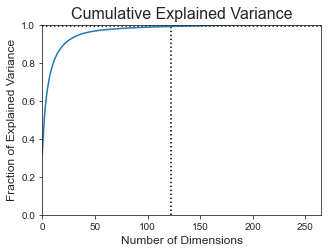

In [75]:
# Set the explained variance threshold
var_cutoff = 0.99

fig,ax = plt.subplots(figsize=(5,3.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax.vlines(dims,0,1,linestyles='dotted')
ax.hlines(var_cutoff,0,len(DF_log_tpm.columns),linestyles='dotted')
ax.set_ylim(0,1)
ax.set_xlim(0,len(DF_log_tpm.columns))
ax.set_ylabel('Fraction of Explained Variance',fontsize=12)
ax.set_xlabel('Number of Dimensions',fontsize=12)
ax.set_title('Cumulative Explained Variance',fontsize=16)
print('Number of dimensions for 99% of variance:',dims)

Finally, plot the first two principle components. The following code colors data by the ``project``. To color by other attributes, change the ``attribute`` variable.

This function requires a few global variables (i.e. ``DF_metadata``, ``DF_weights``, etc.)

In [76]:
def plot_pca(attribute):
    fig,ax = plt.subplots(figsize=(5,5))
    df_metadata_tmp = DF_metadata.copy()
    df_metadata_tmp.fillna('Not reported',inplace=True)
    for name,group in df_metadata_tmp.groupby(attribute):
        ax.scatter(DF_weights.loc[group.index,0],
                   DF_weights.loc[group.index,1],
                   label=name,alpha=0.8)

    ax.set_xlabel('Component 1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=14)
    ax.set_ylabel('Component 2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=14)

    ax.set_title('Principal Component Plot',fontsize=18)
    plt.legend(bbox_to_anchor=(1,1),fontsize=12,ncol=2)

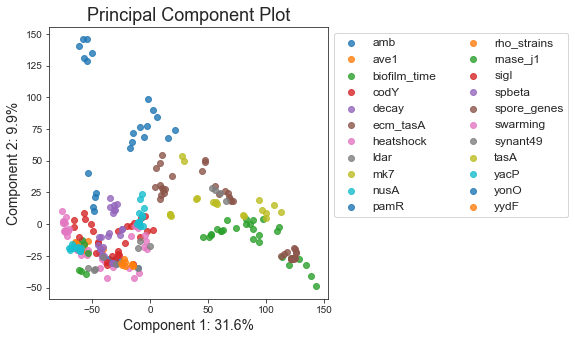

In [77]:
plot_pca('project')

Growth phase seems to explain to the greatest variation in expression, with exponential growth on the left and biofilm/sporulation to the right.

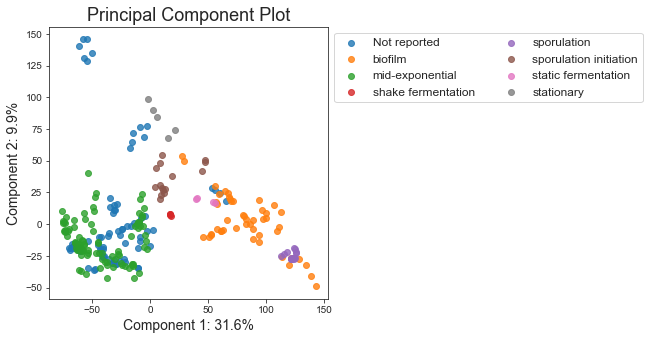

In [78]:
plot_pca('growth_phase')